In [19]:
import numpy as np 

def calculate_reward(verdicts, normalize=True):
    rewards = {None: -2.0, False: -0.5, True: 1.0}
    returns = sum(rewards[v] for v in verdicts) 
    if normalize:
        returns /= len(verdicts)
    return returns

def calculate_task_stats(all_verdicts):
    norm_returns = [calculate_reward(verdicts, normalize=True) for verdicts in all_verdicts]
    mean = np.mean(norm_returns)
    std = np.std(norm_returns)
    return mean, std

In [7]:
import numpy as np
from eval_code_samples import TRANSPOSE, GridComparisonResult, compare_grids
from execution import COMMON_LIBRARY_CODE, multi_process_execute


def multi_execute_transformation(sources, input_grids, random_seeds, timeout=1, function_name="main", num_workers=8):
    input_grids = [np.array(input_grid) for input_grid in input_grids]
            
    codes = []
    for source, input_grid, seed in zip(sources, input_grids, random_seeds):
        try:
            n, m = input_grid.shape
        except:
            breakpoint()
            
        # Create input grid initialization code
        make_input = f"input_grid = np.zeros(({n}, {m}), dtype=int)\n"
        for i in range(n):
            for j in range(m):
                make_input += f"input_grid[{i}][{j}] = {input_grid[i][j]}\n"
        
        # Properly format the common library code and imports
        code = f"""
import numpy as np
import random
random.seed({seed})
np.random.seed({seed})

{COMMON_LIBRARY_CODE}

{source}

{make_input}
try:
    output_grid = {function_name}(input_grid)
    if not isinstance(output_grid, np.ndarray):
        output_grid = "error: output is not a numpy array"
    elif len(output_grid.shape) != 2:
        output_grid = "error: output is not a 2D array"
    elif not np.issubdtype(output_grid.dtype, np.integer):
        output_grid = "error: output contains non-integer values"
except Exception as e:
    output_grid = f"error: {{str(e)}}"
"""
        codes.append(code)

    outputs = multi_process_execute(codes, "output_grid", timeout=timeout, num_workers=num_workers)
    
    # Properly handle string error messages and numpy arrays
    for idx, output in enumerate(outputs):
        if isinstance(output, str):
            outputs[idx] = "error"
        elif isinstance(output, np.ndarray) and len(output.shape) == 2 and np.all((0 <= output) & (output <= 9)):
            outputs[idx] = output
        else:
            outputs[idx] = "error"

    return outputs

def validate(arc_problem, code):
    failure = False
    return_output_grids = []
    train_verdict = False
    
    for idx, train_pair in enumerate(arc_problem.train_pairs + arc_problem.test_pairs):
        if failure: 
            break

        if idx >= len(arc_problem.train_pairs):
            train_verdict = True

        if TRANSPOSE:
            input_grid = train_pair.x.T
            expected_output_grid = train_pair.y.T
        else:
            input_grid = train_pair.x
            expected_output_grid = train_pair.y

        try:
            output_grids = multi_execute_transformation([code], [input_grid], random_seeds=[0], timeout=2, 
                                                      function_name="transform", num_workers=32)
            output_grid = output_grids[0]
        except KeyboardInterrupt:
            exit()
        except Exception as e:
            output_grid = "error"
            print(e)

        comparison_result, ratio = compare_grids(output_grid, expected_output_grid)
        
        # Only convert to list if it's a numpy array
        if isinstance(output_grid, np.ndarray):
            return_output_grids.append(output_grid.tolist())
        else:
            return_output_grids.append(output_grid)

        if comparison_result != GridComparisonResult.EQUAL:
            failure = True
            if comparison_result == GridComparisonResult.ERROR:
                print(f"\t\t[-] Error occurred: {output_grid}")
            elif comparison_result == GridComparisonResult.TYPE_MISMATCH:
                print("\t\t[-] output is not a numpy array")
            elif comparison_result == GridComparisonResult.SHAPE_MISMATCH:
                print(f"\t\t[-] output shape does not match expected shape: {output_grid.shape} vs {expected_output_grid.shape}")
            elif comparison_result == GridComparisonResult.CONTENT_MISMATCH:
                print(f"\t\t[-] comparison failed, ratio of correct elements: {ratio}")

    if not failure: 
        print(f"\t[+] passed")

    return (train_verdict, not failure, return_output_grids)


In [8]:
import json
from arc import train_problems

results_file = "results/arc_train_240/arc_problems_train_240_extra_newline_v2_Llama-3.1-ARC-Potpourri-Induction-8B_temp_0.8_1105182739940769_exec_results_v4.jsonl"
with open(results_file, "r") as f:
    for i, line in enumerate(f):
        d = json.loads(line)
        uid = d["uid"]
        t_indices = [i for i, x in enumerate(d["train_test_verdicts"]) if x == True]
        tf_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if {True, False} == set(x)]
        tfn_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if {True, False, None} == set(x)]
        tn_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if {True, None} == set(x)]
        f_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if {False} == set(x)]
        
        if all(len(v) > 0 for v in [t_indices, tf_indices, tfn_indices, tn_indices, f_indices]):
            print(f"UID: {uid}")
            print(i)
            for train_problem in train_problems:
                if train_problem.uid == uid:
                    arc_problem = train_problem
                    break
            
            t_hs = [d["responses"][i] for i in t_indices]
            tf_hs = [d["responses"][i] for i in tf_indices]
            tfn_hs = [d["responses"][i] for i in tfn_indices]
            tn_hs = [d["responses"][i] for i in tn_indices]
            f_hs = [d["responses"][i] for i in f_indices]
            
            # print(f"All True: {len(t_indices)}")
            # print(t_hs[0])
            # print(f"True False: {len(tf_indices)}")
            # print(tf_hs[0])
            tf_output_grids = []
            print([d["verdicts_per_examples"][i] for i in tf_indices])
            for h in tf_hs:
                # print(h)
                try:
                    train_verdict, train_test_verdict, output_grids = validate(arc_problem, h)
                    tf_output_grids.append(output_grids)
                except Exception as e:
                    print(e)
                break
            # print(f"True False None: {len(tfn_indices)}")
            # print(tfn_hs[0])
            # print(f"True None: {len(tn_indices)}")
            # print(tn_hs[0])
            # print(f"All False: {len(f_indices)}")
            # print(f_hs[0])
            
            # norm_returns = [calculate_reward(verdicts, normalize=False) for verdicts in d["verdicts_per_examples"]]
            # sorted_d = sorted(zip(norm_returns, d["verdicts_per_examples"], d["responses"]), key=lambda x: x[0])
            # with open(f"train_non_seed_results_{uid}.jsonl", 'w') as f:
            #     for r, v, h in sorted_d:
            #         f.write(json.dumps({"reward": r, "verdicts_per_example": v, "response": h}) + "\n")
            break

UID: 23b5c85d
48
[[False, True, False, False, True, False], [False, True, False, False, True, False], [True, True, False, False, False, False], [False, True, False, False, True, False], [False, True, False, False, False, False], [False, False, False, False, True, False], [False, True, False, False, False, False], [False, True, False, False, True, False], [False, True, False, False, True, False], [False, True, False, False, False, False], [True, True, False, False, True, False], [False, True, False, False, True, False], [False, True, False, False, True, False], [False, True, False, False, True, False], [False, False, False, True, False, False], [False, True, False, False, True, False]]
function raised invalid syntax (<string>, line 1562)
		[-] Error occurred: error


In [20]:
import json
from arc import train_problems

results_file = "results/arc_val_400/arc_problems_validation_400_extra_newline_v2_l3.1-8b-inst-fft-induction-barc-heavy-200k-old-200k-lr1e-5-ep2_temp_1.0_mpl_16000_tt_1027134422276239_2009985b_exec_results_v5.jsonl"
with open(results_file, "r") as f:
    for i, line in enumerate(f):
        d = json.loads(line)
        uid = d["uid"]
        t_indices = [i for i, x in enumerate(d["train_test_verdicts"]) if x == True]
        tf_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if {True, False} == set(x)]
        tfn_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if {True, False, None} == set(x)]
        tn_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if {True, None} == set(x)]
        f_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if {False} == set(x)]
        
        if all(len(v) > 0 for v in [t_indices, tf_indices, tfn_indices, tn_indices, f_indices]):
            print(f"UID: {uid}")
            print(i)
            for train_problem in train_problems:
                if train_problem.uid == uid:
                    arc_problem = train_problem
                    break
            
            t_hs = [d["responses"][i] for i in t_indices]
            tf_hs = [d["responses"][i] for i in tf_indices]
            tfn_hs = [d["responses"][i] for i in tfn_indices]
            tn_hs = [d["responses"][i] for i in tn_indices]
            f_hs = [d["responses"][i] for i in f_indices]
            
            # print(f"All True: {len(t_indices)}")
            # print(t_hs[0])
            # print(f"True False: {len(tf_indices)}")
            # print(tf_hs[0])
            print([d["verdicts_per_examples"][i] for i in tf_indices])
            tf_output_grids = [d["output_grids"][i] for i in tf_indices]
            # print(f"True False None: {len(tfn_indices)}")
            # print(tfn_hs[0])
            # print(f"True None: {len(tn_indices)}")
            # print(tn_hs[0])
            # print(f"All False: {len(f_indices)}")
            # print(f_hs[0])
            
            norm_returns = [calculate_reward(verdicts, normalize=False) for verdicts in d["verdicts_per_examples"]]
            sorted_d = sorted(zip(norm_returns, d["verdicts_per_examples"], d["responses"]), key=lambda x: x[0])
            with open(f"val_results_{uid}.jsonl", 'w') as f:
                for r, v, h in sorted_d:
                    f.write(json.dumps({"reward": r, "verdicts_per_example": v, "response": h}) + "\n")
            break

UID: be03b35f
16
[[True, False, False, False], [False, True, False, True], [False, True, False, True], [False, True, False, False], [False, False, False, True], [True, False, False, False], [True, False, False, False]]


In [10]:
tf_output_grids

[[[[1, 0], [1, 1]], [[1, 1], [1, 0]], [[1, 1]], [[0, 1], [1, 1]]],
 [[[1, 1], [0, 1]], [[0, 1], [1, 1]], [[1, 1], [0, 0]], [[1, 1], [1, 0]]],
 [[[1, 1], [0, 1]], [[0, 1], [1, 1]], [[1, 1], [0, 0]], [[1, 1], [1, 0]]],
 [[[0, 1], [1, 1]], [[0, 1], [1, 1]], [[0, 1], [1, 1]], [[0, 1], [1, 1]]],
 [[[1, 1], [1, 0]], [[1, 1], [1, 0]], [[1, 1], [1, 0]], [[1, 1], [1, 0]]],
 [[[1, 0], [1, 1]], [[1, 1], [1, 0]], [[0, 0], [1, 1]], [[0, 1], [1, 1]]],
 [[[1, 0], [1, 1]], [[1, 1], [0, 1]], [[1, 1], [1, 0]], [[1, 1], [0, 1]]]]

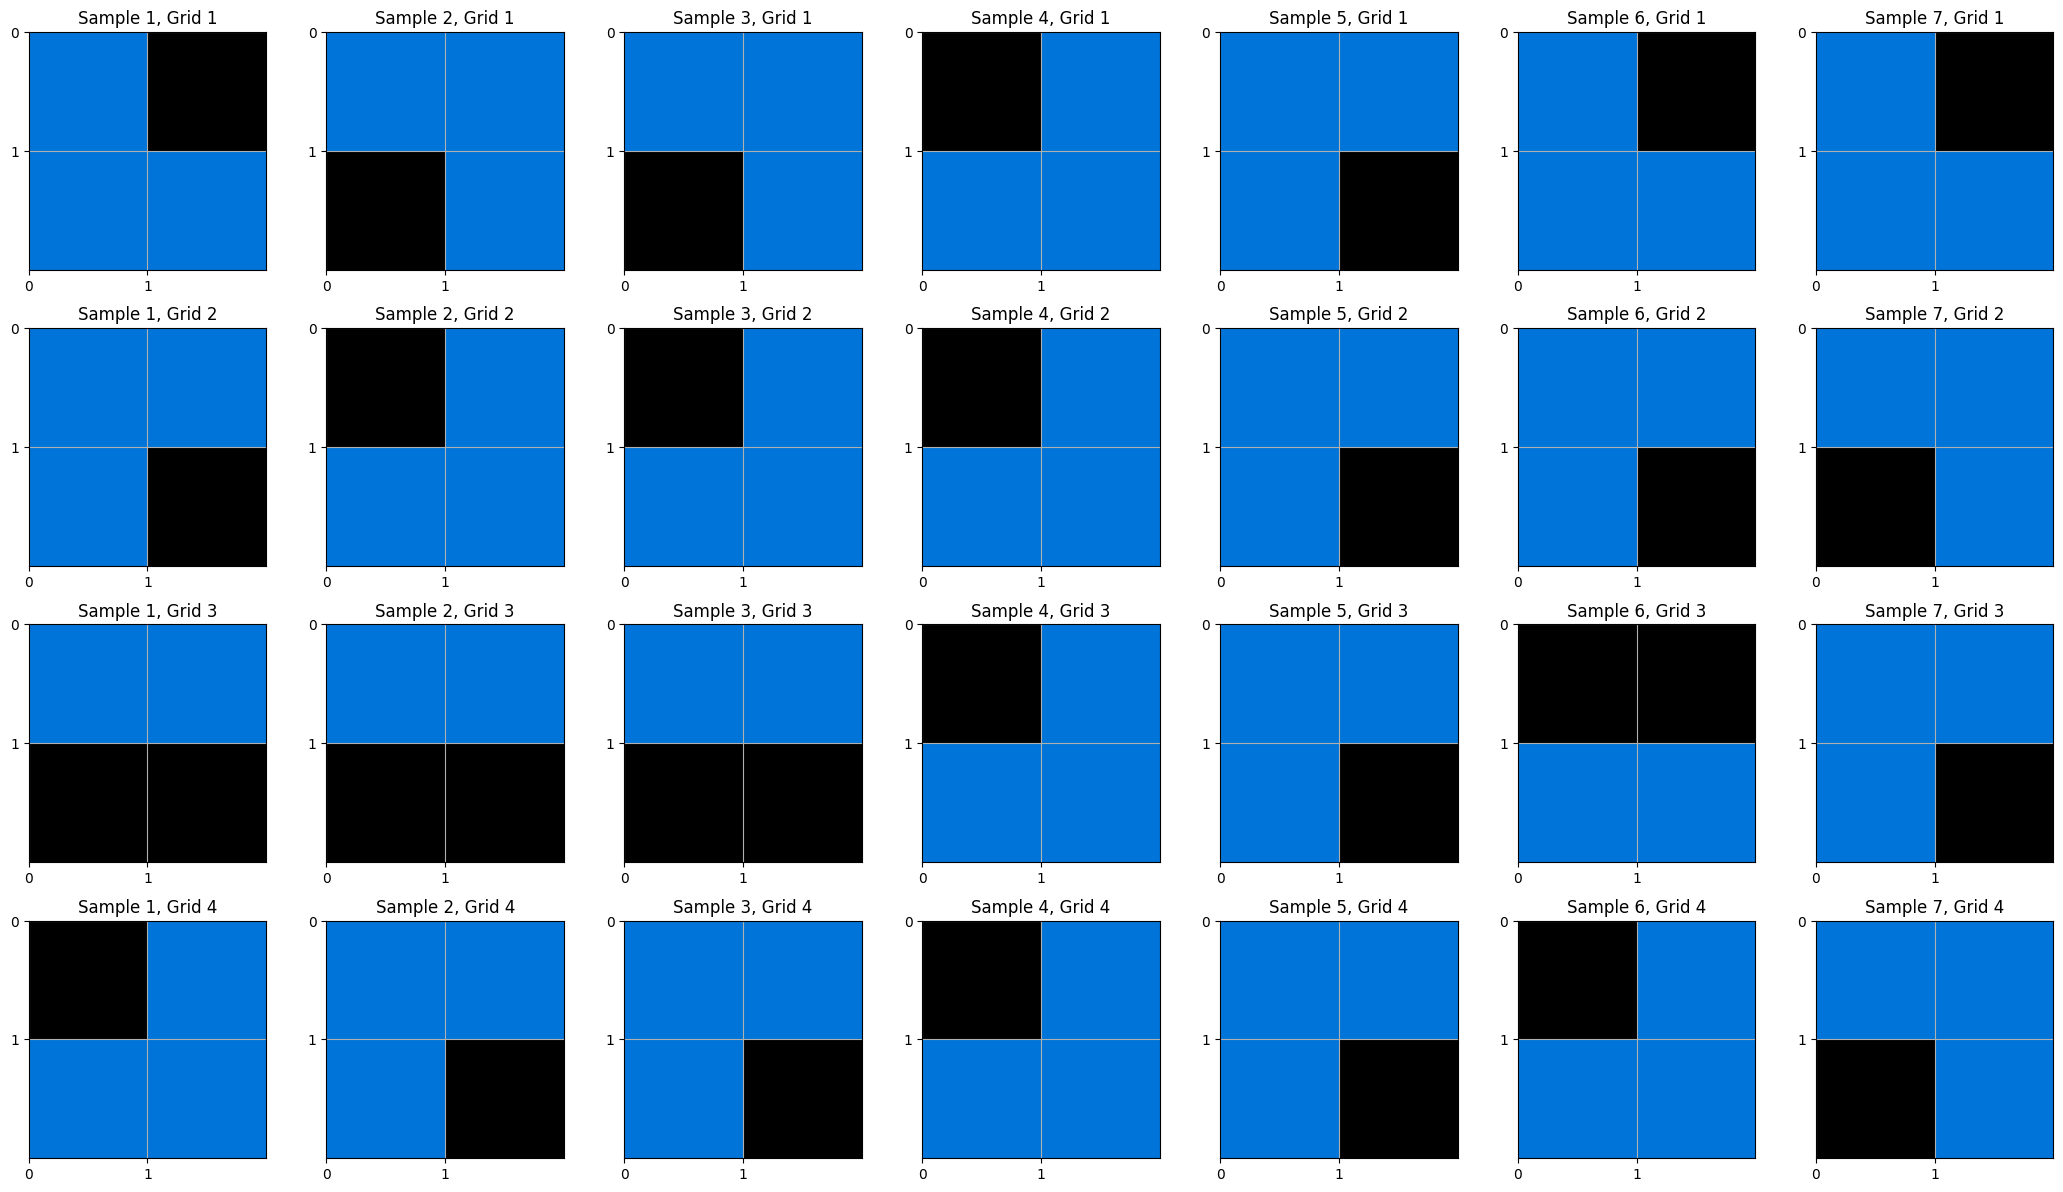

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def visualize_predicted_grids(grids):
    """
    Visualize multiple predicted grids in a transposed subplot layout.
    
    Args:
        grids: List of predicted grids where each grid is a list of lists containing values from 0-9
    """
    # Convert input to numpy arrays and determine dimensions
    n_samples = len(grids)
    n_subgrids = len(grids[0])
    
    # Create figure with subplots - now transposed
    fig, axs = plt.subplots(n_subgrids, n_samples, 
                           figsize=(3*n_samples, 3*n_subgrids),
                           squeeze=False)
    
    # Define color scheme exactly as in the reference
    colors_rgb = {
        0: (0x00, 0x00, 0x00),  # Black
        1: (0x00, 0x74, 0xD9),  # Blue
        2: (0xFF, 0x41, 0x36),  # Red
        3: (0x2E, 0xCC, 0x40),  # Green
        4: (0xFF, 0xDC, 0x00),  # Yellow
        5: (0xA0, 0xA0, 0xA0),  # Gray
        6: (0xF0, 0x12, 0xBE),  # Pink
        7: (0xFF, 0x85, 0x1B),  # Orange
        8: (0x7F, 0xDB, 0xFF),  # Light Blue
        9: (0x87, 0x0C, 0x25),  # Dark Red
    }
    
    # Convert RGB colors to float values (0-1)
    float_colors = [tuple(c / 255 for c in col) for col in colors_rgb.values()]
    arc_cmap = ListedColormap(float_colors)
    
    # Plot each grid - now with transposed indexing
    for i in range(n_samples):
        for j in range(n_subgrids):
            # Convert grid to numpy array
            grid_array = np.array(grids[i][j])
            
            # Create mesh plot
            axs[j, i].pcolormesh(
                grid_array,
                cmap=arc_cmap,
                rasterized=True,
                vmin=0,
                vmax=9
            )
            
            # Set grid lines
            axs[j, i].set_xticks(np.arange(0, grid_array.shape[1], 1))
            axs[j, i].set_yticks(np.arange(0, grid_array.shape[0], 1))
            axs[j, i].grid(True)
            
            # Set aspect ratio and invert y-axis
            axs[j, i].set_aspect(1)
            axs[j, i].invert_yaxis()
            
            # Add labels
            axs[j, i].set_title(f'Sample {i+1}, Grid {j+1}')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Handle variable size grids by padding
def pad_grids(grids):
    """Pad grids to make them uniform size"""
    max_rows = max(max(len(grid) for grid in sample) for sample in grids)
    max_cols = max(max(len(row) for grid in sample for row in grid) for sample in grids)
    
    padded_grids = []
    for sample in grids:
        padded_sample = []
        for grid in sample:
            # Pad each grid to max size with zeros
            padded_grid = np.zeros((max_rows, max_cols))
            for i, row in enumerate(grid):
                for j, val in enumerate(row):
                    padded_grid[i, j] = val
            padded_sample.append(padded_grid)
        padded_grids.append(padded_sample)
    
    return padded_grids


# Pad and visualize the grids
padded_grids = pad_grids(tf_output_grids)
visualize_predicted_grids(padded_grids)

In [4]:
print(tf_hs[0])

Let's solve this puzzle using Python code with the common library functions. We'll first reason about the problem and then write the code to solve it. The `transform` function will take the input grid and return the output grid. Here is the Python code with the comments describing how to solve the problem:
```python
from common import *

import numpy as np
from typing import *

# concepts:
# color extraction, cropping, counting

# description:
# In the input, you will see a grid containing several colored objects on a black background. Each object has a unique color and consists of multiple pixels. 
# To make the output, find the object with the fewest pixels, and return a grid that contains just that object, cropping out the black background.

def transform(input_grid: np.ndarray) -> np.ndarray:
    # Step 1: Find all connected components (objects) in the input grid
    objects = find_connected_components(input_grid, background=Color.BLACK, connectivity=4, monochromatic=False)

    # 

In [34]:
tf_output_grids

[]

In [26]:
def show_colored_grid(grid):
    """
    internal function not used by LLM
    Not used by the language model, used by the rest of the code for debugging
    """

    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    # RGB
    colors_rgb = {
        0: (0x00, 0x00, 0x00),
        1: (0x00, 0x74, 0xD9),
        2: (0xFF, 0x41, 0x36),
        3: (0x2E, 0xCC, 0x40),
        4: (0xFF, 0xDC, 0x00),
        5: (0xA0, 0xA0, 0xA0),
        6: (0xF0, 0x12, 0xBE),
        7: (0xFF, 0x85, 0x1B),
        8: (0x7F, 0xDB, 0xFF),
        9: (0x87, 0x0C, 0x25),
    }

    _float_colors = [tuple(c / 255 for c in col) for col in colors_rgb.values()]
    arc_cmap = ListedColormap(_float_colors)
    grid = grid.T
    plt.figure()
    plot_handle = plt.gca()
    plot_handle.pcolormesh(
        grid,
        cmap=arc_cmap,
        rasterized=True,
        vmin=0,
        vmax=9,
    )
    plot_handle.set_xticks(np.arange(0, grid.shape[1], 1))
    plot_handle.set_yticks(np.arange(0, grid.shape[0], 1))
    plot_handle.grid()
    plot_handle.set_aspect(1)
    plot_handle.invert_yaxis()
    plt.show()

In [28]:
show_colored_grid(tf_output_grid)

AttributeError: 'NoneType' object has no attribute 'T'

In [1]:
import json
from collections import Counter
import os

num_pairs = {}
results_dir = "results/arc_val_400"
for file in os.listdir(results_dir):
    results_file = os.path.join(results_dir, file)
    
    with open(results_file, "r") as f:
        for line in f:
            d = json.loads(line)
            uid = d["uid"]
            num_pairs[uid] = len(d["verdicts_per_examples"][0])
    break
        

In [2]:
import pickle
from collections import Counter
val_counter = Counter()
norm_rewards = pickle.load(open("reward_distributions/ARC_Potpourri_Induction_8B_arc_train_240_64/task_rewards.pkl", "rb"))
for k, v in norm_rewards.items():
    val_counter["all_true"] += len([x for x in v if x == 1.0])
    val_counter["partially_true"] += len([x for x in v if -0.5 < x < 1.0])
val_counter

Counter({'partially_true': 956, 'all_true': 897})

In [9]:
import json
from collections import Counter

counter = Counter()
results_file = "results/arc_train_240/arc_problems_train_240_extra_newline_v2_Llama-3.1-ARC-Potpourri-Induction-8B_temp_0.8_1105182739940769_exec_results_v4.jsonl"
with open(results_file, "r") as f:
    for line in f:
        d = json.loads(line)
        uid = d["uid"]
        t_indices = [i for i, x in enumerate(d["train_test_verdicts"]) if x == True]
        t_other_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if ({True} != set(x) and True in set(x))]
        counter["all_true"] += len(t_indices)
        counter["partially_true"] += len(t_other_indices)
        
counter

Counter({'partially_true': 1052, 'all_true': 897})

In [4]:
import json
from collections import Counter

counter = Counter()
results_file = "/mnt/nas/suehyun/BARC/results/re_arc_240/arc_problems_re_arc_240_extra_newline_v2_Llama-3.1-ARC-Potpourri-Induction-8B_temp_0.8_1106144751388516_exec_results_v4.jsonl"
with open(results_file, "r") as f:
    for line in f:
        d = json.loads(line)
        uid = d["uid"]
        t_indices = [i for i, x in enumerate(d["train_test_verdicts"]) if x == True]
        t_other_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if ({True} != set(x) and True in set(x))]
        if len(t_indices) > 0:
            print(uid)
            print(len(t_indices), '\t', len(t_other_indices))
        counter["all_true"] += len(t_indices)
        counter["partially_true"] += len(t_other_indices)
        
counter

1f876c06_gen_6
2 	 3
543a7ed5_gen_0
3 	 2
ac0a08a4_gen_3
36 	 0
ff805c23_gen_8
17 	 18
68b16354_gen_2
1 	 1
a740d043_gen_0
2 	 6
9565186b_gen_1
13 	 8
9edfc990_gen_5
1 	 0
7468f01a_gen_2
1 	 0
6150a2bd_gen_4
11 	 3
e40b9e2f_gen_3
3 	 18
b8825c91_gen_2
1 	 23
a61f2674_gen_7
1 	 0
c8f0f002_gen_2
6 	 18
c59eb873_gen_0
8 	 1
7fe24cdd_gen_7
1 	 0
3c9b0459_gen_2
1 	 1
67a3c6ac_gen_3
9 	 1
cdecee7f_gen_1
1 	 1
5582e5ca_gen_1
3 	 27
74dd1130_gen_0
30 	 5
b91ae062_gen_0
29 	 10
d9fac9be_gen_6
1 	 4
a8d7556c_gen_2
22 	 4
dc0a314f_gen_4
1 	 29
bda2d7a6_gen_0
4 	 10
d037b0a7_gen_2
1 	 3
b9b7f026_gen_0
3 	 21
f76d97a5_gen_2
2 	 6
445eab21_gen_3
1 	 3
50cb2852_gen_1
3 	 7
62c24649_gen_4
22 	 0
5bd6f4ac_gen_0
5 	 20
46442a0e_gen_2
1 	 1
4c4377d9_gen_0
2 	 0
dbc1a6ce_gen_4
1 	 0
b1948b0a_gen_6
21 	 3
23b5c85d_gen_0
3 	 6
f25ffba3_gen_2
7 	 0
67e8384a_gen_1
27 	 9
40853293_gen_7
1 	 0
f25fbde4_gen_1
7 	 15
9ecd008a_gen_7
2 	 30
39a8645d_gen_2
2 	 0
9172f3a0_gen_6
43 	 2
3af2c5a8_gen_3
33 	 0
be94b721_g

Counter({'partially_true': 670, 'all_true': 399})

In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter

def get_differences(results_file):
    # Store the differences
    differences = []

    # Read and process the data
    if results_file.endswith(".jsonl"):
        with open(results_file, "r") as f:
            for line in f:
                d = json.loads(line)
                t_indices = [i for i, x in enumerate(d["train_test_verdicts"]) if x == True]
                t_other_indices = [i for i, x in enumerate(d["verdicts_per_examples"]) if ({True} != set(x) and True in set(x))]
                
                if len(t_indices) > 0:
                    differences.append(len(t_indices) - len(t_other_indices))
    elif results_file.endswith(".pkl"):
        norm_rewards = pickle.load(open(results_file, "rb"))
        for k, v in norm_rewards.items():
            t = len([x for x in v if x == 1.0])
            t_other = len([x for x in v if -0.5 < x < 1.0])
            if t > 0:
                differences.append(t - t_other)
    return differences


def plot_perseverance(title, results_file):
    differences = get_differences(results_file)
    # Create the histogram
    plt.figure(figsize=(5, 3))
    plt.hist(differences, bins='auto', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Difference\n(# correct hypotheses - # partially correct hypotheses)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Add mean and median lines
    mean_diff = np.mean(differences)
    median_diff = np.median(differences)
    plt.axvline(mean_diff, color='red', linestyle='dashed', label=f'Mean: {mean_diff:.2f}')
    plt.axvline(median_diff, color='green', linestyle='dashed', label=f'Median: {median_diff:.2f}')
    plt.legend()

    # Show some basic statistics
    print(f"Number of cases: {len(differences)}")
    print(f"Mean difference: {mean_diff:.2f}")
    print(f"Median difference: {median_diff:.2f}")
    print(f"Standard deviation: {np.std(differences):.2f}")
    print(f"Min difference: {min(differences)}")
    print(f"Max difference: {max(differences)}")
    
    plt.show()

Number of cases: 47
Mean difference: 1.66
Median difference: 1.00
Standard deviation: 14.85
Min difference: -28
Max difference: 41


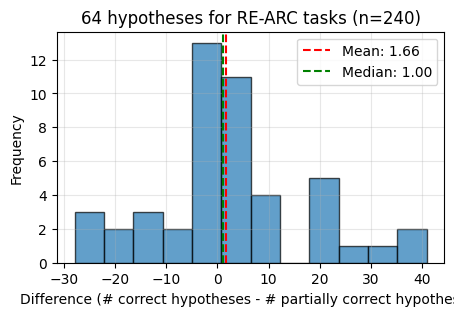

In [21]:
plot_perseverance("64 hypotheses for RE-ARC tasks (n=240)", "/mnt/nas/suehyun/BARC/results/re_arc_240/arc_problems_re_arc_240_extra_newline_v2_Llama-3.1-ARC-Potpourri-Induction-8B_temp_0.8_1106144751388516_exec_results_v4.jsonl")

Number of cases: 81
Mean difference: 3.25
Median difference: 1.00
Standard deviation: 21.20
Min difference: -45
Max difference: 63


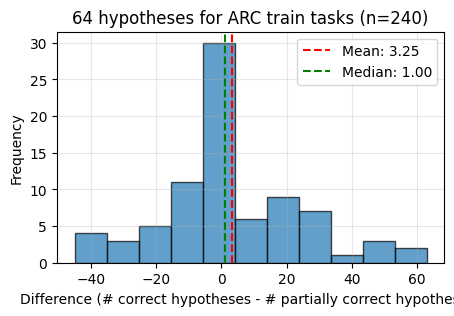

In [19]:
plot_perseverance(
    "64 hypotheses for ARC train tasks (n=240)",
    "results/arc_train_240/arc_problems_train_240_extra_newline_v2_Llama-3.1-ARC-Potpourri-Induction-8B_temp_0.8_1105182739940769_exec_results_v4.jsonl"
)

Number of cases: 152
Mean difference: -47.61
Median difference: -15.50
Standard deviation: 3481.47
Min difference: -15317
Max difference: 17439


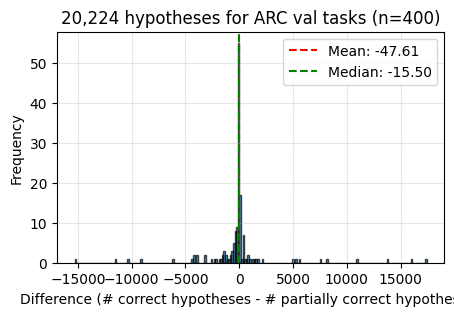

In [22]:
plot_perseverance(
    "20,224 hypotheses for ARC val tasks (n=400)",
    "reward_distributions/ARC_Potpourri_Induction_8B_val_20k/task_rewards.pkl"
)

Number of cases: 66
Mean difference: -0.74
Median difference: 1.00
Standard deviation: 61.01
Min difference: -187
Max difference: 183


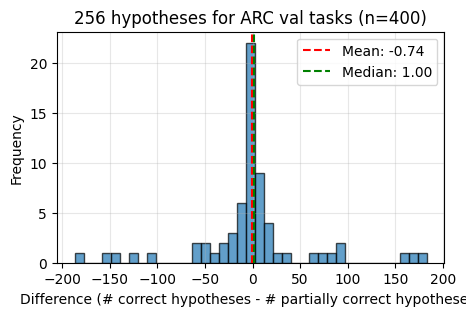

In [24]:
plot_perseverance(
    "256 hypotheses for ARC val tasks (n=400)",
    "results/arc_val_400/arc_problems_validation_400_extra_newline_v2_l3.1-8b-inst-fft-induction-barc-heavy-200k-old-200k-lr1e-5-ep2_temp_1.0_mpl_16000_tt_1027134422276239_2009985b_exec_results_v5.jsonl"
)

In [6]:
import os
import json
import pandas as pd
from collections import Counter

counter = Counter()
for root, _, files in os.walk("reward_distributions"):
    for file in files:
        if file == "task_stats.json":
            with open(os.path.join(root, file), "r") as f:
                d = json.load(f)
                for uid, stats in d.items():
                    if stats["max"] == 1.0:
                        counter[root] += 1
                    
print(counter)
            

reward_distributions/ARC_Potpourri_Induction_8B_re_arc_240_64
reward_distributions/ARC_Potpourri_Induction_8B_arc_train_240_64
reward_distributions/ARC_Potpourri_Induction_8B_val_20k
Counter({'reward_distributions/ARC_Potpourri_Induction_8B_val_20k': 152, 'reward_distributions/ARC_Potpourri_Induction_8B_arc_train_240_64': 81, 'reward_distributions/ARC_Potpourri_Induction_8B_re_arc_240_64': 47})
